In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rqalpha.apis import *
from rqoptimizer import *
from rqoptimizer.utils import *
from rqdatac import *
from rqalpha_plus import run_func
import warnings
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from functools import wraps
warnings.filterwarnings("ignore")
rqdatac.init()

In [7]:
symbol = '510300.XSHG'
start = "2014-01-01"
end = "2023-12-31"
frequency = "1d"
df_price_am = get_price(symbol, start, end, frequency)[['close','open']]
df_price_am.head()

close    open
order_book_id date                      
510300.XSHG   2014-01-02  1.9879  1.9887
              2014-01-03  1.9661  1.9795
              2014-01-06  1.9191  1.9602
              2014-01-07  1.9199  1.9056
              2014-01-08  1.9182  1.9199

### 拥挤指标考量

In [3]:
def get_turnover(stock_list, start, end):
    # 一个月换手率滚动平均
    turnover_rate = get_turnover_rate(stock_list, start, end, 'month')
    turnover_rate = turnover_rate.unstack(level = 0)
    turnover_rate.columns = turnover_rate.columns.droplevel(0)
    return turnover_rate

def get_vol(stock_list, start, end):
    # 一个月波动平均
    price = get_price(stock_list, start,end, frequency = '1d')[['close']]
    price['daily_return'] = price.groupby(level=0)['close'].pct_change()
    rolling_vol = price.groupby(level=0)['daily_return'].rolling(window=20, min_periods=1).std()
    rolling_vol = rolling_vol.reset_index(level=0, drop=True)
    price['rolling_vol'] = rolling_vol
    vol = price[['rolling_vol']].unstack(level = 0)
    vol.columns = vol.columns.droplevel(0)
    return vol

def get_beta(stock_list, start, end):
    # 计算20日beta均值
    beta = get_stock_beta(stock_list, start, end).rolling(20,min_periods = 1).mean()
    return beta

def get_index_metrics(stock_list,start, end):
    turnover = get_turnover(stock_list,start, end)
    vol = get_vol(stock_list,start, end)
    beta = get_beta(stock_list,start, end)
    avg_turnover = turnover.mean(axis=1)
    avg_vol = vol.mean(axis=1)
    avg_beta = beta.mean(axis=1)
    result = pd.concat([avg_turnover, avg_vol, avg_beta], axis=1)
    result.columns = ['turnover_avg', 'vol_avg', 'beta_avg']
    return result


df_etf = all_instruments(type='ETF' , market = 'cn')
code = df_etf[df_etf.order_book_id == '510300.XSHG'].underlying_order_book_id.values[0]
stk_list = index_components(code)
index_metrics = get_index_metrics(stk_list, start='2014-01-01', end='2023-12-31')
index_metrics

,turnover_avg,vol_avg,beta_avg
2014-01-02,1.105082,NaN,0.918895
2014-01-03,1.092597,NaN,0.915838
2014-01-06,1.030881,0.017967,0.920033
2014-01-07,1.018715,0.021071,0.922126
2014-01-08,1.005984,0.020349,0.923334
...,...,...,...
2023-12-25,0.770276,0.015341,0.980749
2023-12-26,0.764904,0.015318,0.981177
2023-12-27,0.763249,0.015369,0.981661
2023-12-28,0.785219,0.017380,0.982937


In [4]:
index_metrics = index_metrics.fillna(0).mean(axis=1)

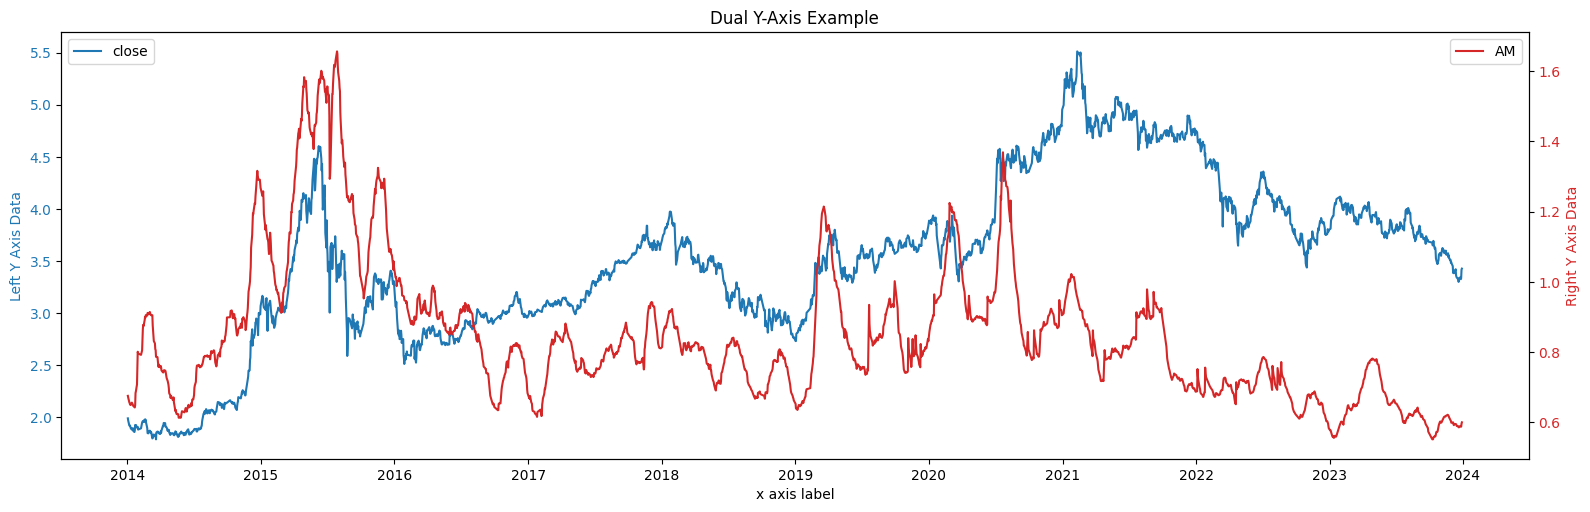

In [5]:
fig, ax1 = plt.subplots(figsize = (16,5))

color = 'tab:blue'
ax1.set_xlabel('x axis label')
ax1.set_ylabel('Left Y Axis Data', color=color)
ax1.plot(df_price_am.index.levels[1], df_price_am['close'].values, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:red'
ax2.set_ylabel('Right Y Axis Data', color=color)
ax2.plot(df_price_am.index.levels[1], index_metrics.values, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 
plt.title('Dual Y-Axis Example')
ax1.legend(['close'], loc='upper left')
ax2.legend(['AM'], loc='upper right')

plt.show()

# AM FM

In [8]:
df_price_entry = get_price(symbol, start, end, frequency)[['close']].unstack(level = 0)
df_price_entry.columns = df_price_entry.columns.droplevel(0)
frequency_h = '60m'
df_price_exit = get_price(symbol, start, end, frequency_h)[['close']].unstack(level = 0)
df_price_exit.columns = df_price_exit.columns.droplevel(0)

In [9]:
# 计算价格波动AM
df = df_price_am.copy()
df['Deriv'] = df['close'] - df['open']
df['Envel'] = df['Deriv'].abs().rolling(window=4).max()
df['Volatil'] = df['Envel'].rolling(window=8).mean()

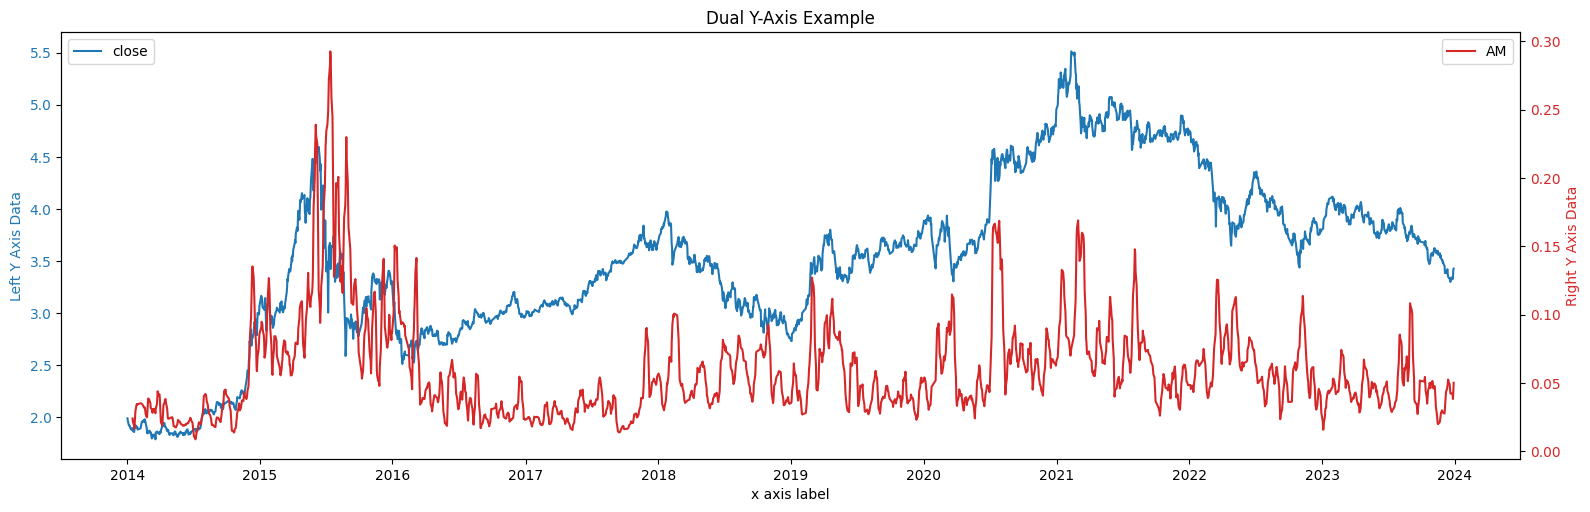

In [10]:
fig, ax1 = plt.subplots(figsize = (16,5))

color = 'tab:blue'
ax1.set_xlabel('x axis label')
ax1.set_ylabel('Left Y Axis Data', color=color)
ax1.plot(df.index.levels[1], df['close'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:red'
ax2.set_ylabel('Right Y Axis Data', color=color)
ax2.plot(df.index.levels[1], df['Volatil'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 
plt.title('Dual Y-Axis Example')
ax1.legend(['close'], loc='upper left')
ax2.legend(['AM'], loc='upper right')

plt.show()

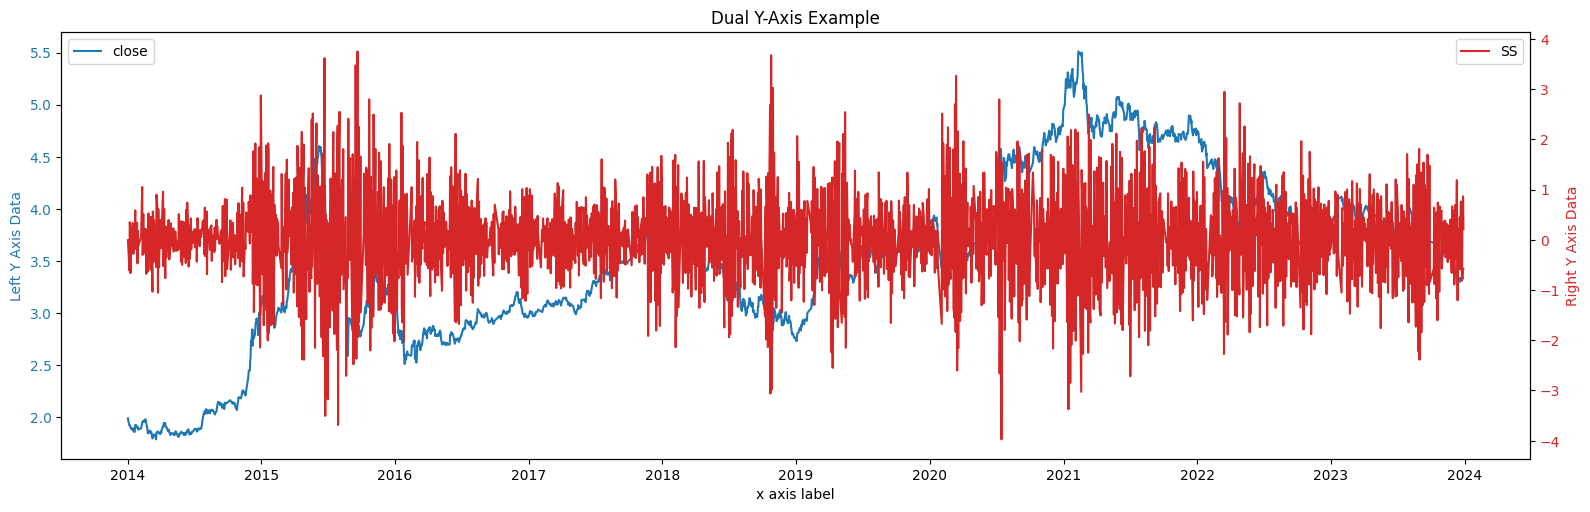

In [12]:
# 计算价格波动FM

df['Deriv'] = df['close'] - df['open']
# 滤除AM噪音
df['HL'] = 10 * df['Deriv']
df['HL'] = np.clip(df['HL'], -1, 1)

# super_smoother超级平滑器
def super_smoother(data, period):
    # 计算SuperSmoother系数
    a1 = np.exp(-1.414 * np.pi / period)
    b1 = 2 * a1 * np.cos(1.414 * 180 / period)
    c2 = b1
    c3 = -a1 * a1
    c1 = 1 - c2 - c3

    # 初始化输出序列
    ss = np.zeros_like(data)
    ss[:2] = data[:2]  # 使用前两个值作为初始化值

    # 应用SuperSmoother公式
    for i in range(2, len(data)):
        ss[i] = c1 * (data[i] + data[i-1]) / 2 + c2 * ss[i-1] + c3 * ss[i-2]

    return ss
df['SS'] = super_smoother(df['HL'], 30)

fig, ax1 = plt.subplots(figsize = (16,5))

color = 'tab:blue'
ax1.set_xlabel('x axis label')
ax1.set_ylabel('Left Y Axis Data', color=color)
ax1.plot(df.index.levels[1], df['close'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:red'
ax2.set_ylabel('Right Y Axis Data', color=color)
ax2.plot(df.index.levels[1], df['SS'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 
plt.title('Dual Y-Axis Example')
ax1.legend(['close'], loc='upper left')
ax2.legend(['SS'], loc='upper right')

plt.show()

均值：0.023
标准差：0.897
偏度：-0.013
峰度：1.213


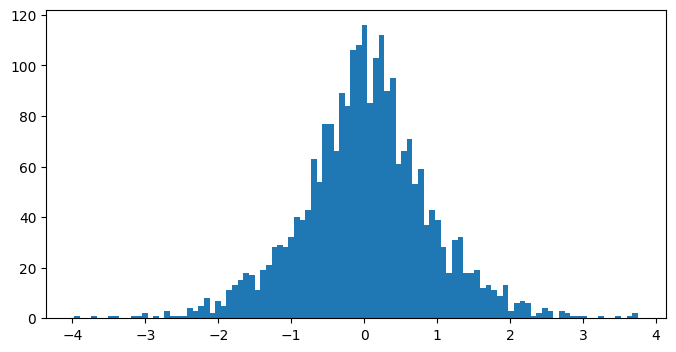

In [13]:
print('均值：%.3f' %df['SS'].mean())
print('标准差：%.3f' %df['SS'].std())
print('偏度：%.3f' %df['SS'].skew())
print('峰度：%.3f' %df['SS'].kurt())
y = list(range(50))
plt.figure(figsize=(8,4))
plt.hist(df['SS'], bins=100)
plt.show()

In [14]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['SS'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -9.739691
p-value: 0.000000


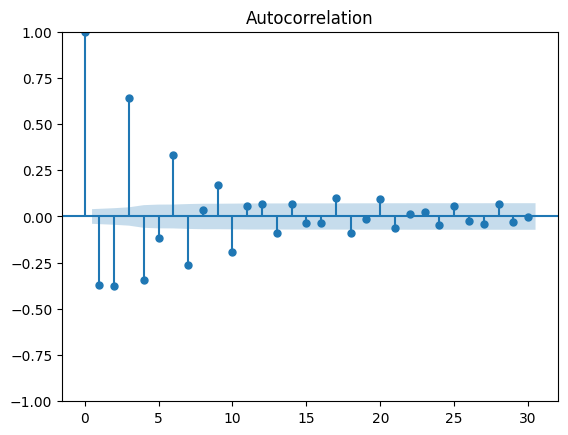

In [15]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(df['SS'],use_vlines=True,lags=30)  #"lags"自相关函数的滞后取值范围，此处之后30阶，绘制出原始数据"ts"的自相关图
plt.show()

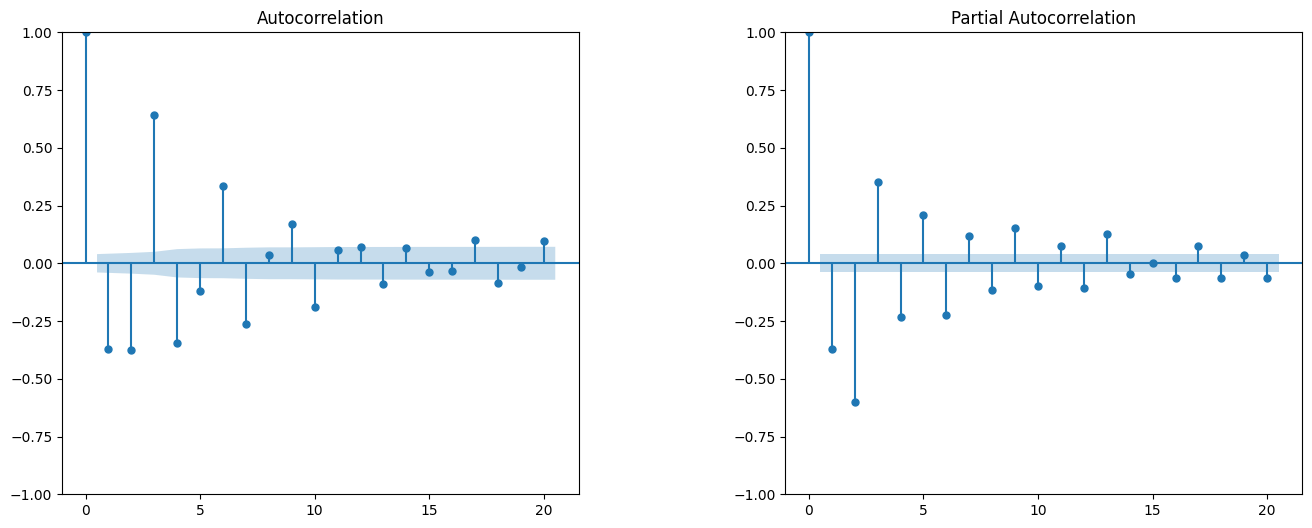

In [16]:
fig,(ax1,ax2)=plt.subplots(1, 2, figsize=(16, 6))
#绘制ACF图
plot_acf(df['SS'].dropna(), 
         ax=ax1, 
         lags=20
         )  #设置lags参数来控制滞后的阶数
ax1.set_title('Autocorrelation')
#绘制PACF图
plot_pacf(df['SS'].dropna(),
          ax=ax2, 
          lags=20
          ) #设置lags参数来控制滞后的阶数
ax2.set_title('Partial Autocorrelation')
#调整子图之间的间距
plt.subplots_adjust(wspace=0.4)
#显示图形
plt.show()

In [17]:
from itertools import product
ps = range(0, 10, 1)
qs = range(0, 10, 1)
order_list = list(product(ps, qs))
          
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX
def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) ->  pd.DataFrame:
    results = []
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
          
        aic = model.aic
        results.append([order, aic])
          
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    result_df = result_df.sort_values(by='AIC',  ascending=True).reset_index(drop=True)
          
    return result_df
          
result_df = optimize_ARMA(df['SS'][:500], order_list)
result_df

  0%|          | 0/100 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(5, 4)",970.245453
1,"(5, 5)",971.170739
2,"(5, 3)",971.499366
3,"(6, 8)",972.205832
4,"(5, 6)",973.060774
...,...,...
95,"(2, 0)",1183.571965
96,"(0, 1)",1301.416450
97,"(1, 1)",1303.389615
98,"(1, 0)",1362.919581


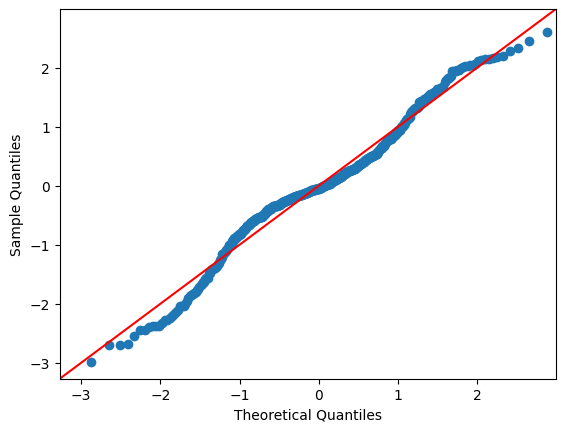

In [18]:
model = SARIMAX(endog=df['SS'][:500], order=(5,0,4), simple_differencing=False)
model_fit = model.fit(disp=False)
residuals = model_fit.resid
#Q-Q plot
from statsmodels.graphics.gofplots import qqplot
qqplot(residuals, fit=True,line='45');

In [19]:
# 对残差进行Ljung-Box检验，残差序列不存在自相关关系
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(residuals, np.arange(1, 11, 1))

,lb_stat,lb_pvalue
1,0.375766,0.539878
2,0.597392,0.741785
3,0.612944,0.893463
4,1.081798,0.897149
5,1.093859,0.954646
6,1.618404,0.951245
7,1.633514,0.977324
8,1.812310,0.986235
9,2.111460,0.989580
10,3.220091,0.975760


In [22]:
model = SARIMAX(endog=df['SS'][:500], order=(5,0,4), simple_differencing=False)
results=model.fit()
predicted_mean = results.forecast(5)
predicted_mean

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.87875D-01    |proj g|=  1.09274D-01

At iterate    5    f=  9.72184D-01    |proj g|=  6.34792D-02

At iterate   10    f=  9.63123D-01    |proj g|=  3.47033D-02

At iterate   15    f=  9.52288D-01    |proj g|=  7.60931D-02

At iterate   20    f=  9.51185D-01    |proj g|=  6.28989D-03

At iterate   25    f=  9.50766D-01    |proj g|=  2.62346D-02

At iterate   30    f=  9.50539D-01    |proj g|=  6.82560D-03

At iterate   35    f=  9.50477D-01    |proj g|=  4.86045D-03

At iterate   40    f=  9.50446D-01    |proj g|=  1.00125D-03

At iterate   45    f=  9.50431D-01    |proj g|=  5.83912D-03

At iterate   50    f=  9.50245D-01    |proj g|=  8.32490D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

500    1.442513
501   -0.924897
502   -0.232782
503    0.906940
504   -0.512104
Name: predicted_mean, dtype: float64

In [38]:
df_SS[500:505]

,SS,predicted_SS
date,,
2016-01-19,2.527506,1.442513
2016-01-20,-1.321762,-0.977591
2016-01-21,-1.643238,-1.043947
2016-01-22,1.873082,1.994424
2016-01-25,-0.925526,-0.482062


In [39]:
df_SS[:500]

,SS,predicted_SS
date,,
2014-01-02,-0.008000,NaN
2014-01-03,-0.134000,NaN
2014-01-06,-0.609939,NaN
2014-01-07,0.349622,NaN
2014-01-08,0.272200,NaN
...,...,...
2016-01-12,-0.276812,NaN
2016-01-13,-0.058755,NaN
2016-01-14,0.783029,NaN


In [25]:
df_SS = df[['SS']].reset_index()
df_SS = df_SS[['date','SS']].set_index('date')
df_SS

,SS
date,
2014-01-02,-0.008000
2014-01-03,-0.134000
2014-01-06,-0.609939
2014-01-07,0.349622
2014-01-08,0.272200
...,...
2023-12-25,-0.813297
2023-12-26,0.151392
2023-12-27,0.328183


In [31]:
predicted_SS = []
for i in range(500, 800):
    model = SARIMAX(df_SS['SS'][:i], order=(5,0,4), simple_differencing=False)
    model_fit = model.fit(disp=0)
    forecast = model_fit.forecast(5)
    predicted_SS.append(forecast.values[0])

[1.4425130118441831,
 -0.9775910895018207,
 -1.0439469629938245,
 1.9944236466719365,
 -0.48206219583235516,
 -0.8251202754835543,
 1.1067045632588968,
 0.2937340122369352,
 -0.7205631135009093,
 0.938175228962732,
 -1.4743144920550448,
 0.763105831985055,
 -0.1650098034694404,
 -0.36675182111802535,
 0.12715413921637714,
 0.25284911531635024,
 -0.6048914841226152,
 -0.022526739486436947,
 0.2183534062803777,
 -0.029285635683797613,
 0.035762771091491695,
 -0.02443440806298535,
 0.19841236262802153,
 -0.5394971076058158,
 1.4413195502515352,
 -1.034422306133611,
 0.3903607769008021,
 -0.22306714874093375,
 -1.1147491858522514,
 1.507034290178849,
 -0.863097912640322,
 -0.3714860465089743,
 0.915424852184564,
 -0.5574252206410022,
 0.40520216296868017,
 -0.16388725128403392,
 -0.5892607187742571,
 0.793293887542874,
 -0.4311303045896024,
 -0.4682705767627958,
 0.36339152695677995,
 -0.3548540251798757,
 0.4093299803151015,
 -0.013629248852744727,
 -0.05126743145067705,
 -0.0808226023585

In [35]:
df_SS['predicted_SS'] = pd.Series(predicted_SS, index=df_SS.index[500:800])
df_SS[500:510]

,SS,predicted_SS
date,,
2016-01-19,2.527506,1.442513
2016-01-20,-1.321762,-0.977591
2016-01-21,-1.643238,-1.043947
2016-01-22,1.873082,1.994424
2016-01-25,-0.925526,-0.482062
2016-01-26,-2.026980,-0.825120
2016-01-27,0.905816,1.106705
2016-01-28,-0.483831,0.293734
2016-01-29,0.182303,-0.720563


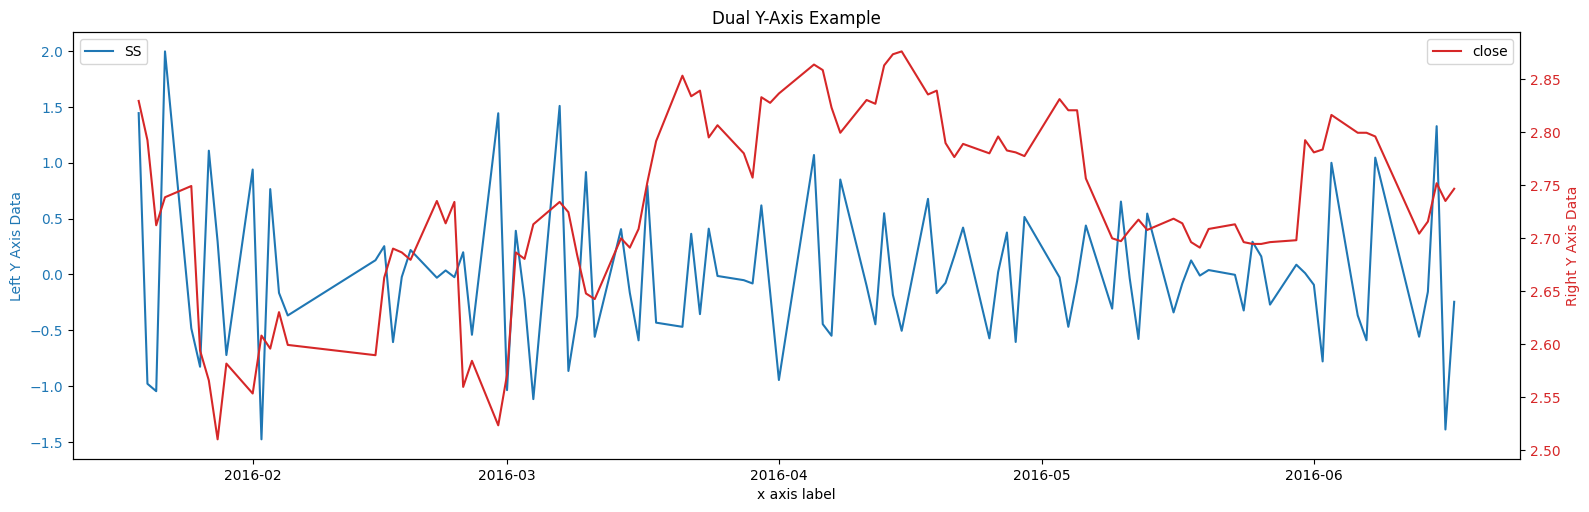

In [55]:
fig, ax1 = plt.subplots(figsize = (16,5))

color = 'tab:blue'
ax1.set_xlabel('x axis label')
ax1.set_ylabel('Left Y Axis Data', color=color)
ax1.plot(df_price_am.index.levels[1][500:600], df_SS['predicted_SS'][500:600], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:red'
ax2.set_ylabel('Right Y Axis Data', color=color)
ax2.plot(df_price_am.index.levels[1][500:600], df_price_am['close'][500:600], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 
plt.title('Dual Y-Axis Example')
ax1.legend(['SS'], loc='upper left')
ax2.legend(['close'], loc='upper right')

plt.show()

In [60]:
np.corrcoef(df_SS['predicted_SS'][500:800].values, df_price_am['close'][500:800].values)

array([[ 1.00000000e+00, -7.72566566e-04],
       [-7.72566566e-04,  1.00000000e+00]])

### 以上为研究，以下为回测

2016-01-20 00:00:00: 买入 510300.XSHG, 价格 2.7922, 数量 1700
2016-01-22 11:30:00: 卖出 510300.XSHG, 价格 2.6997, 数量 1700
2016-01-25 00:00:00: 买入 510300.XSHG, 价格 2.749, 数量 1700
2016-01-26 15:00:00: 卖出 510300.XSHG, 价格 2.5939, 数量 1700
2016-01-26 00:00:00: 买入 510300.XSHG, 价格 2.5939, 数量 1800
2016-01-28 15:00:00: 卖出 510300.XSHG, 价格 2.5102, 数量 1800
2016-02-02 00:00:00: 买入 510300.XSHG, 价格 2.608, 数量 1800
2016-02-29 10:30:00: 卖出 510300.XSHG, 价格 2.5093, 数量 1800
2016-03-01 00:00:00: 买入 510300.XSHG, 价格 2.571, 数量 1700
2016-03-07 14:00:00: 卖出 510300.XSHG, 价格 2.7111, 数量 1700
2016-03-08 00:00:00: 买入 510300.XSHG, 价格 2.7243, 数量 1700
2016-03-11 10:30:00: 卖出 510300.XSHG, 价格 2.6212, 数量 1700
2016-03-16 00:00:00: 买入 510300.XSHG, 价格 2.7085, 数量 1700
2016-04-05 15:00:00: 卖出 510300.XSHG, 价格 2.8635, 数量 1700
2016-04-06 00:00:00: 买入 510300.XSHG, 价格 2.8583, 数量 1600
2016-04-20 14:00:00: 卖出 510300.XSHG, 价格 2.7499, 数量 1600
2016-04-20 00:00:00: 买入 510300.XSHG, 价格 2.7895, 数量 1600
2016-05-09 11:30:00: 卖出 510300.XSHG, 价格 2.7058, 数量 

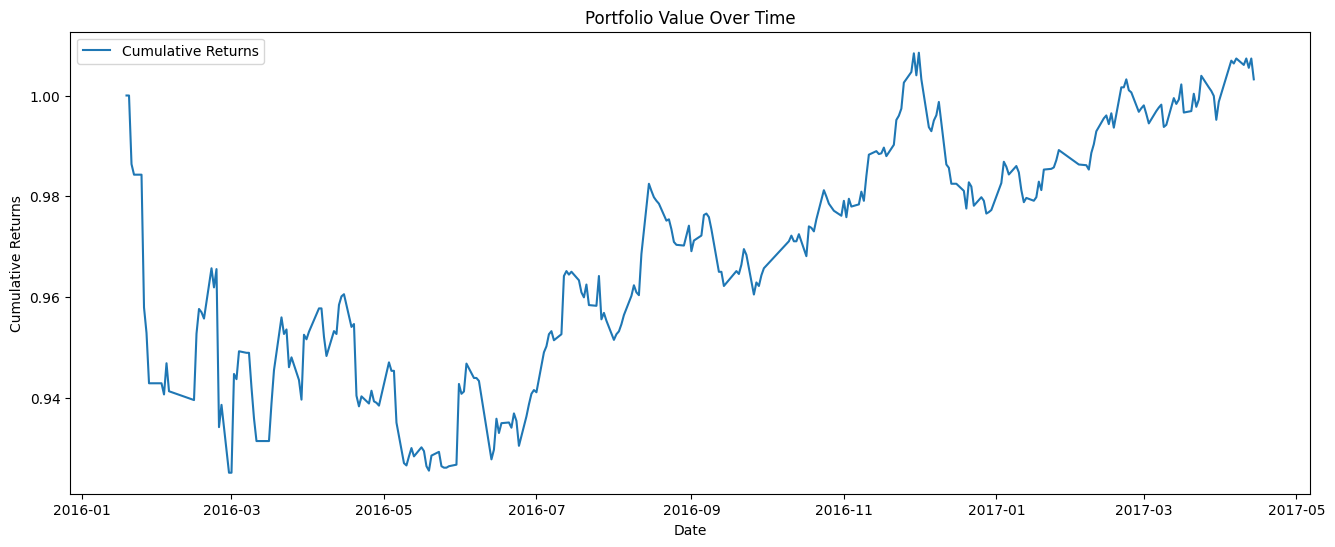

初始资金: 10000
最终资金: 10032.089999999997
年化收益率: 0.27%
最大回撤: -7.49%
未考虑无风险利率的夏普比率: 0.03
交易次数: 29


In [49]:
df = df_price_entry[500:800]
count = 0
initial_capital = 10000
positions = 2
slippage_and_fees = 0.00  # 滑点
portfolio_value_tracker = []

capital = initial_capital
cash = initial_capital
etf_value = 0
holdings = {etf: 0 for etf in df.columns} 
peak = {etf: 0 for etf in df.columns}
# 初始止损位和止盈位
stop_loss_point = {etf: 0 for etf in df.columns}
take_profit_point = {etf: 0 for etf in df.columns}
entry_price = {etf: 0 for etf in df.columns}


def check_buy_signals(etf, current_date, df_SS):
    next_date = current_date + pd.Timedelta(days=1)
    if next_date not in df_SS.index:
        return False
    if df_SS.loc[next_date, 'predicted_SS'] > df_SS.loc[current_date, 'SS']:
        return True
    return False

def buy(etf, price, date):
    global capital, cash, etf_value, holdings, count
    if not np.isnan(price) and holdings[etf] == 0:
        num_held_etfs = sum(1 for h in holdings.values() if h > 0)
        if num_held_etfs < positions:
            investable_cash = cash / (positions - num_held_etfs)
            etf_amount = int(investable_cash * (1 - slippage_and_fees) / price) // 100 * 100
            holdings[etf] = etf_amount
            cash -= etf_amount * price 
            entry_price[etf] = price 
            stop_loss_point[etf] = price * 0.97
            take_profit_point[etf] = price * 1.06
            print(f"{date}: 买入 {etf}, 价格 {price}, 数量 {etf_amount}")
            count += 1

def check_stop_conditions(etf, price):
    global stop_loss_point, take_profit_point

    if holdings[etf] <= 0:
        return False
    if price < stop_loss_point[etf]:
        return True

    if price >= take_profit_point[etf]:
        stop_loss_point[etf] = take_profit_point[etf]
        take_profit_point[etf] = entry_price[etf] * (1 + 0.01 * (int((price / entry_price[etf] - 1) / 0.01) + 1))
    return False

def sell(etf, price, date):
    global capital, cash, etf_value, holdings,count
    if not np.isnan(price) and holdings[etf] > 0:
        proceeds = holdings[etf] * price * (1 - slippage_and_fees)
        cash += proceeds 
        etf_value -= holdings[etf] * price
        print(f"{date}: 卖出 {etf}, 价格 {price}, 数量 {holdings[etf]}")
        holdings[etf] = 0
        count+=1

start_date = pd.to_datetime('2016-01-19')
# 主循环 循环df_price_entry和df_price_exit
trading_hours = ['10:30', '11:30', '14:00', '15:00']
for date, prices_daily in df.iterrows():
    date_str = date.strftime('%Y-%m-%d')
    for trading_hour in trading_hours:
        datetime_str = f"{date_str} {trading_hour}"
        datetime_index = pd.to_datetime(datetime_str)
        if datetime_index in df_price_exit.index:
            prices_hourly = df_price_exit.loc[datetime_index]

            # 循环 df_price_exit小时线数据找准时机出场
            for etf in prices_daily.index:
                if etf in prices_hourly and not np.isnan(prices_hourly[etf]):
                    price_hourly = prices_hourly[etf]
                    if check_stop_conditions(etf, price_hourly):
                        sell(etf, price_hourly, datetime_index)
    
    # 循环 df_price_entry 日线数据卖出
    for etf in prices_daily.index:
        price_data_daily = df[etf].loc[:date]
        if check_buy_signals(etf , date, df_SS):
            num_held_etfs = sum(1 for h in holdings.values() if h > 0)
            if num_held_etfs < positions:
                buy(etf, prices_daily[etf], date)
    etf_value = sum(holdings[etf] * prices_daily[etf] for etf in prices_daily.index if holdings[etf] > 0)
    capital = cash + etf_value
    portfolio_value_tracker.append(capital)

portfolio_values = np.array(portfolio_value_tracker)
returns = portfolio_values[1:] / portfolio_values[:-1] - 1
cumulative_returns = portfolio_values / initial_capital - 1

# 年化收益率
annualized_return = (portfolio_values[-1] / portfolio_values[0])**(250/len(portfolio_values))-1
rolling_max = np.maximum.accumulate(portfolio_values)
daily_drawdown = portfolio_values / rolling_max - 1
max_drawdown = np.min(daily_drawdown)

average_daily_return = np.mean(returns)
annualized_dev = np.std(returns) * np.sqrt(252)
sharp_ratio = annualized_return / annualized_dev

plt.figure(figsize=(16, 6))
plt.plot(df.index, portfolio_values/10000, label='Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Portfolio Value Over Time')
plt.legend()
plt.show()

print(f"初始资金: {initial_capital}")
print(f"最终资金: {portfolio_values[-1]}")
print(f"年化收益率: {annualized_return:.2%}")
print(f"最大回撤: {max_drawdown:.2%}")
print(f"未考虑无风险利率的夏普比率: {sharp_ratio:.2f}")
print(f"交易次数: {count}")